# (2.2) Expected Maximization Algorithm initialization using the segmentations from Tissue models (1.1)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import cv2 as cv
import scipy
import scipy.stats as stats
import scipy.special as special
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

In [1]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


# Functions

In [3]:
def read_patients_list(test_set_path):
    
    # Read files in the test-set:
    aux_patients_list = os.listdir(test_set_path + '/testing-images')
    
    patients_list = []
    for str in aux_patients_list:
        if not str.startswith('.'):
            # Remove ".nii.gz" in the "testing-images" folder
            patients_list.append(str.replace(".nii.gz", ""))
    return patients_list

# save the array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)


def image_registration(fixed_path, moving_path):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    fixedImage = sitk.ReadImage(fixed_path)
    movingImage = sitk.ReadImage(moving_path)

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    #Set resampler interpolator as NearestNeighbor
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    
    return resultImage, transformParameterMap


def transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap):
    """Transform the atlas to the moving image space

    Args:
        atlas_path_csf (str): path to the csf atlas
        atlas_path_gm (str): path to the gm atlas
        atlas_path_wm (str): path to the wm atlas
        transformParameterMap (transformix map): transformation map

    Returns:
        sitk image, sitk image, sitk image: transformed csf atlas, transformed gm atlas, transformed wm atlas
    """
    atlas_csf = sitk.ReadImage(atlas_path_csf) #Read labels
    atlas_gm = sitk.ReadImage(atlas_path_gm) #Read labels
    atlas_wm = sitk.ReadImage(atlas_path_wm) #Read labels
    
    transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
    transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform map
    transformixImageFilter.SetMovingImage(atlas_csf) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_csf_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_gm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_gm_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_wm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_wm_registered = transformixImageFilter.GetResultImage() #Get result image

    return atlas_csf_registered, atlas_gm_registered, atlas_wm_registered   
    

In [7]:
def k_means(skull_stripped, mask):
    
    # We start off by flattening image
    flat_skull_stripped = np.float32( skull_stripped.reshape(-1) )

    # We run k-means algorithm for 3 clusters ( CSF+air will be assigned as label 1 and separated in masking step)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 1)
    k_value = 3
    _, labels, (centers) = cv.kmeans(flat_skull_stripped, k_value, None, criteria, 10,cv.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]

    # Reshape back to the original image dimension and convert it to the original labels
    segmented_image = segmented_image.reshape(skull_stripped.shape)

    level = np.unique(segmented_image)
    for k in range(k_value): # Labels: 1->Air+CSF, 2->WM, 3->GM
        segmented_image = np.where(segmented_image==level[k], k+1, segmented_image)

    # Masking step (this way, air is now labeled as 0)
    segmented_image = mask*segmented_image

    return segmented_image



def label_propagation(patient_name, segmentations_dir):

    segmented_image = sitk.GetArrayFromImage(sitk.ReadImage(segmentations_dir + f'/seg_ours_labelProp_{patient_name}.nii'))
    return segmented_image



def tissues_model(patient_name, segmentations_dir):
    
    segmented_image = sitk.GetArrayFromImage(sitk.ReadImage(segmentations_dir + f'/seg_ours_Tmodels_{patient_name}.nii'))
    return segmented_image



def EM_initialization_method(skull_stripped, method, mask, patient_name, segmentations_dir):
    if method == 'k_means':
        return k_means(skull_stripped, mask)
    if method == 'tissues_model':
        return tissues_model(patient_name, segmentations_dir)
    else:
        return label_propagation(patient_name, segmentations_dir)


# EM funcitons

In [8]:
def print_dices(labels, gt_labels):
    labels = labels.flatten()
    gt_labels = gt_labels.flatten()

    print(f'Dice for tissue 1 is = {sum( (labels==1)*(gt_labels==1) ) / sum(gt_labels==1)}')
    print(f'Dice for tissue 2 is = {sum( (labels==2)*(gt_labels==2) ) / sum(gt_labels==2)}')
    print(f'Dice for tissue 3 is = {sum( (labels==3)*(gt_labels==3) ) / sum(gt_labels==3)}')
    return


def e_step(flat_skull_stripped, params, in_brain):
    """Expectation step: compute the log-likelihood "log_px" for all pixels of the image.

    Args:
        flat_skull_stripped : Gray intensity image, flattened into 1-D
        params :              Dictionary of parameters
        in_brain :            Ground truth that only discerns between those pixels inside the skull and outside

    Returns:
        log_px :        loglikelihood of the Gaussians mixture
        new_labels :    labels map obtained from clustering each pixel by maximum probability 
    """
    
    # For implementation purposes we compute the loglikelihood: log( p(x) ) = log( a1*N1 +...+ ak*Nk ). This preserves orders for maximum argument
    log_px = np.log([ params['alpha1'], params['alpha2'], params['alpha3'] ])[np.newaxis, ...] + \
             np.log([stats.multivariate_normal(params["mean1"], params["sigma1"]).pdf(flat_skull_stripped),
                    stats.multivariate_normal(params["mean2"], params["sigma2"]).pdf(flat_skull_stripped),
                    stats.multivariate_normal(params["mean3"], params["sigma3"]).pdf(flat_skull_stripped)]).T
    
    # We generate a mask with the new labels based on their maximum probability
    new_labels = np.zeros(log_px.shape[0])
    for i in range(log_px.shape[0]):
        if in_brain[i]:         # If pixel "i" is inside the brain
            new_labels[i] = np.argmax(log_px[i][:]) + 1
    
    return log_px, new_labels


def m_step(skull_stripped, labels):
    """This function computes the alpha-weight, mean and variance of each tissue

    Args:
        skull_stripped: original skull-stripped MRI in grayscale values, flattened
        labels:              mask with labels 0, ..., 3

    Returns:
        params: dictionary of parameters
    """
    flat_skull_stripped = skull_stripped.flatten()
    flat_labels = labels.flatten()
    
    # Compute the alpha-weights (ratio of pixels in each cluster):
    d_pixels = sum(flat_labels>0)
    
    params = {'mean1': np.mean(flat_skull_stripped, where=(flat_labels==1)),
              'mean2': np.mean(flat_skull_stripped, where=(flat_labels==2)),
              'mean3': np.mean(flat_skull_stripped, where=(flat_labels==3)),
              
              'sigma1': np.var(flat_skull_stripped, where=(flat_labels==1)),
              'sigma2': np.var(flat_skull_stripped, where=(flat_labels==2)),
              'sigma3': np.var(flat_skull_stripped, where=(flat_labels==3)),
              
              'alpha1': sum(flat_labels==1) / d_pixels,
              'alpha2': sum(flat_labels==2) / d_pixels,
              'alpha3': sum(flat_labels==3) / d_pixels,
              }
    return params



def run_em(skull_stripped, initial_labels, mask, gt_labels):
    """
    This function runs EM algorithm stopping only when less than a given number of pixels have changed since previous iteration
    """
    print('Initial dices:')
    print_dices(initial_labels, gt_labels)
    
    plt.imshow(initial_labels[150,::-1,:], cmap ="gray")
    plt.axis('off')
    plt.show()
    
    # Flatten all images for implementability purposes
    flat_skull_stripped = skull_stripped.flatten()
    previous_labels = initial_labels.flatten()
    flat_mask = mask.flatten()
    
    # Compute Gaussians Mixture parameters from initial labels
    params = m_step(skull_stripped, initial_labels)
    
    
    d = len(flat_skull_stripped)
    iters = 0
    error_track = []
    
    while True:
        
        # Compute loglikelihood and new labels
        loglikelihood, labels = e_step(flat_skull_stripped, params, flat_mask)
        
        changed_pixels = d - sum(previous_labels == labels)
        error_track.append(changed_pixels)
        
        # Stopping criteria:
        if len(error_track) > 2 and error_track[-1] < 1000: # Stop when less than 1000 pixels have changed
            print(f"Number of changing pixels in iteration {iters} is: {changed_pixels}")
            reshaped_labels = labels.reshape(skull_stripped.shape)
            print_dices(reshaped_labels, gt_labels)
            break
        
        # If stopping criteria not fulfilled, update variables for next iteration
        params = m_step(flat_skull_stripped, labels)
        previous_labels = labels
        
        reshaped_labels = labels.reshape(skull_stripped.shape)
        print(f"Number of changing pixels in iteration {iters} is: {changed_pixels}")
        print_dices(reshaped_labels, gt_labels)
        
        iters += 1
        
    _, final_labels = e_step(flat_skull_stripped, params, flat_mask)
    
    return final_labels.reshape(skull_stripped.shape), error_track

# EM with 3 different initializations

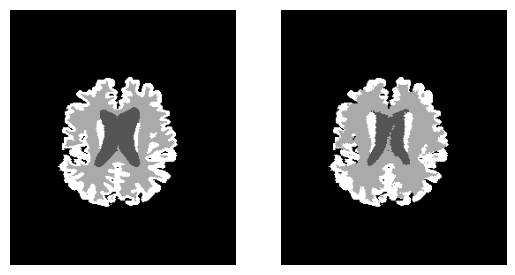

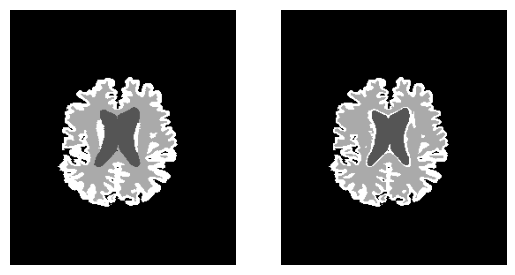

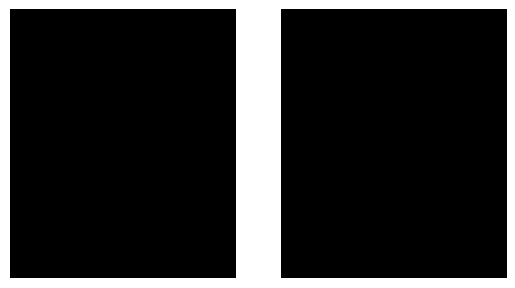

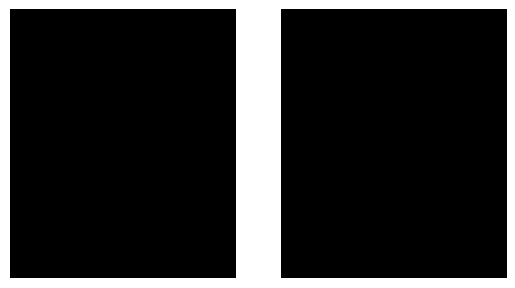

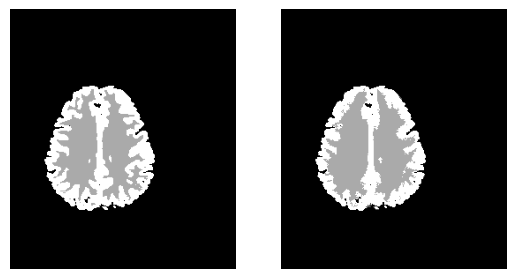

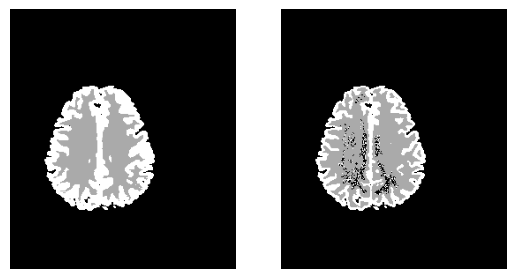

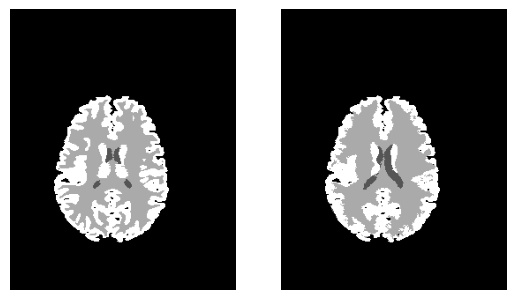

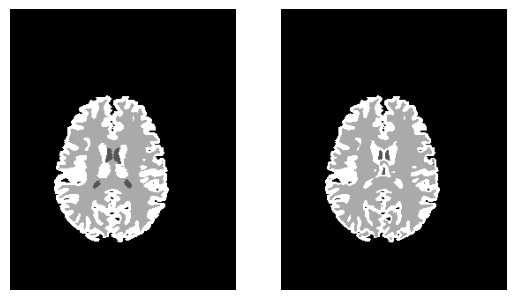

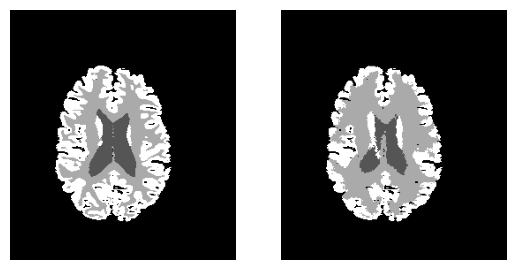

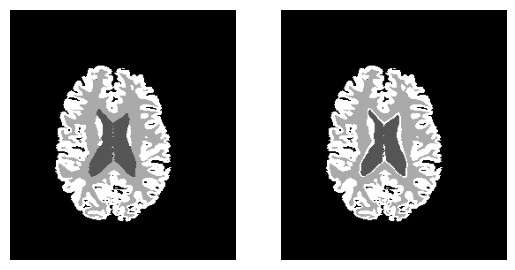

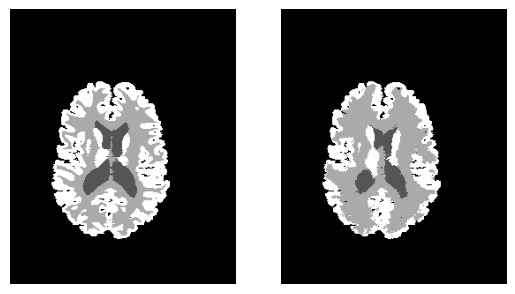

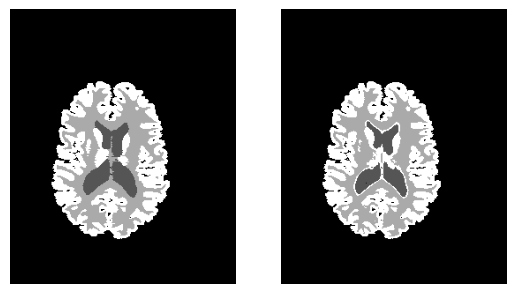

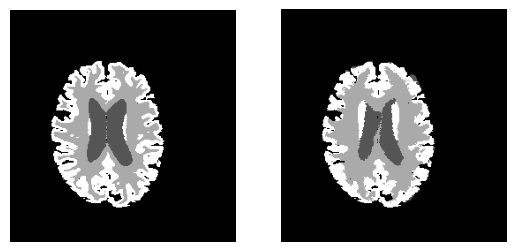

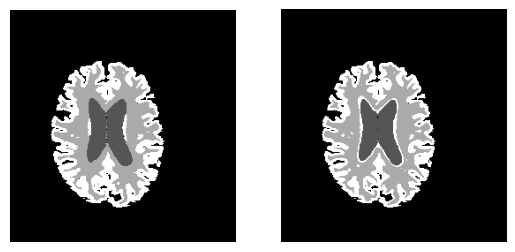

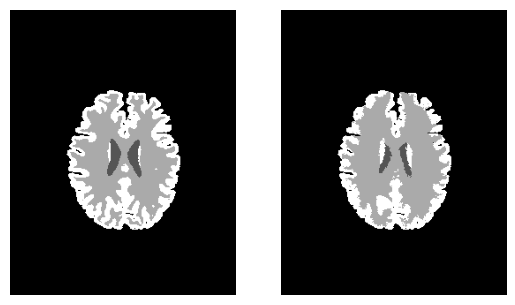

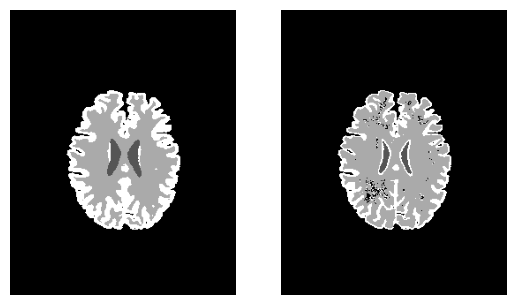

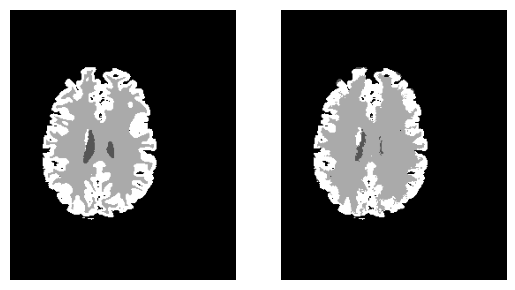

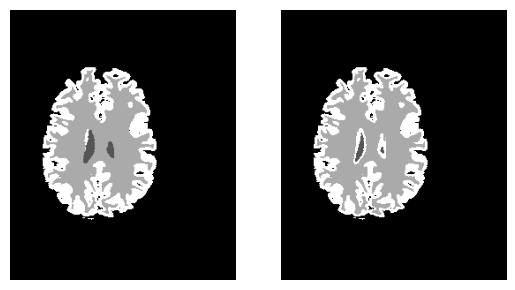

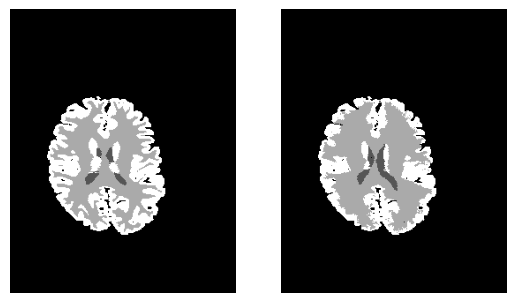

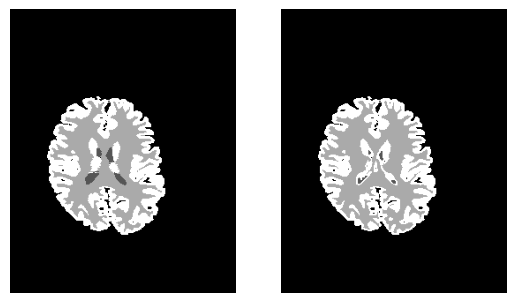

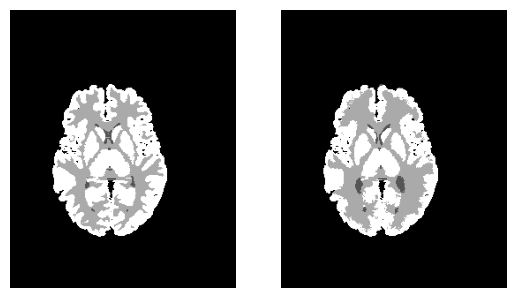

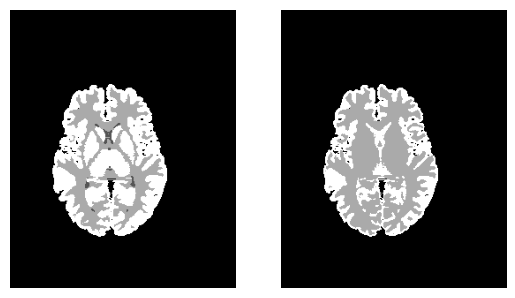

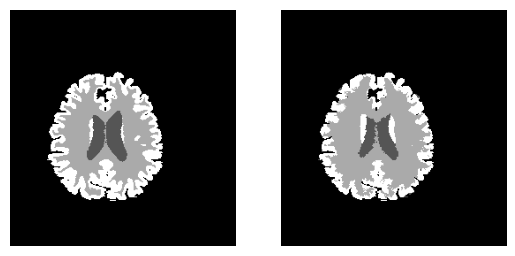

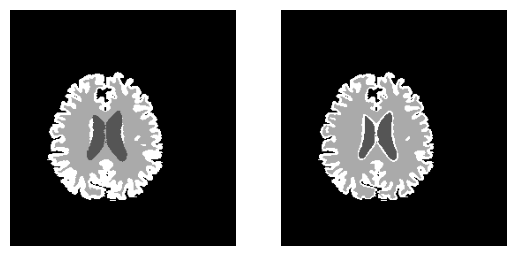

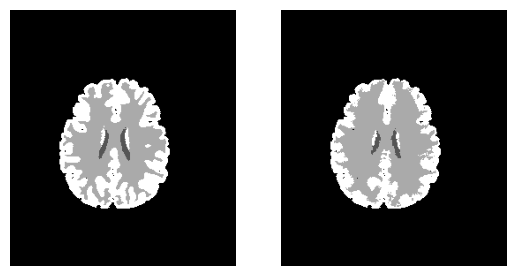

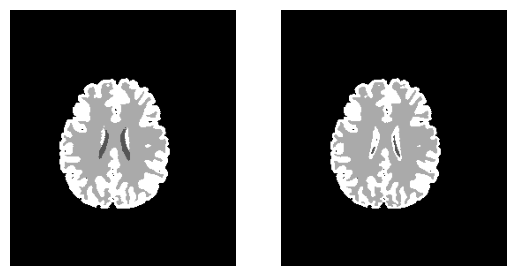

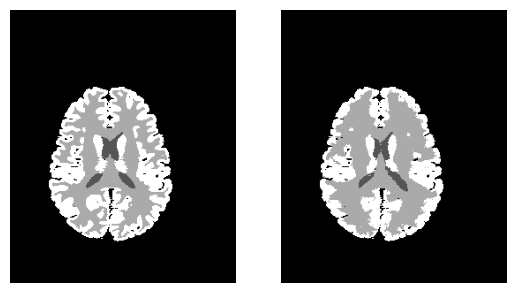

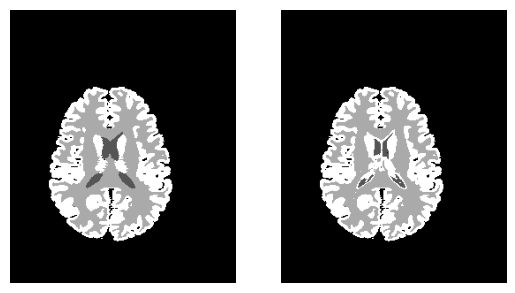

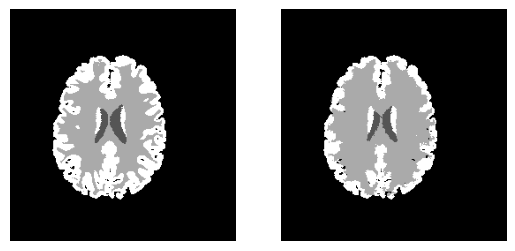

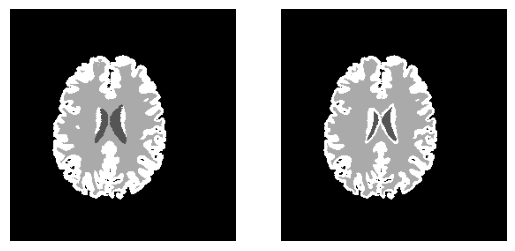

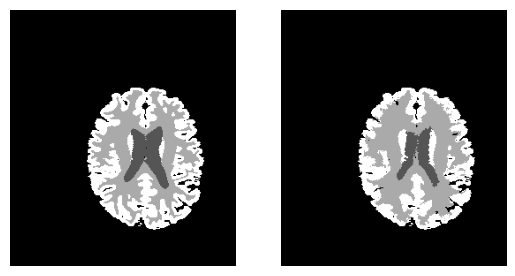

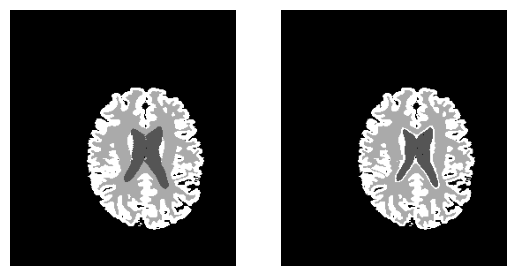

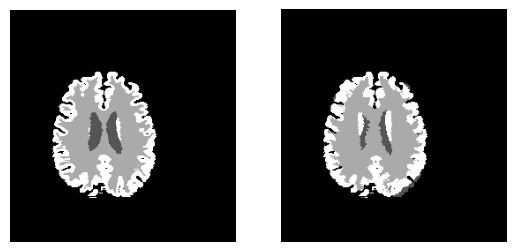

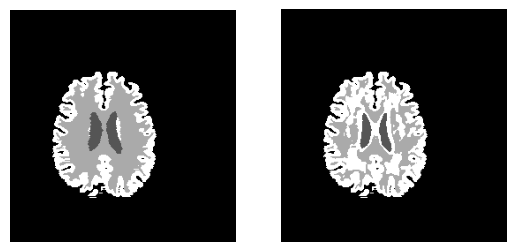

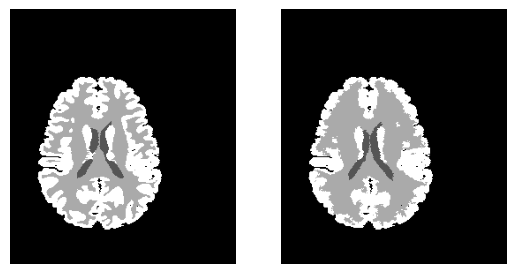

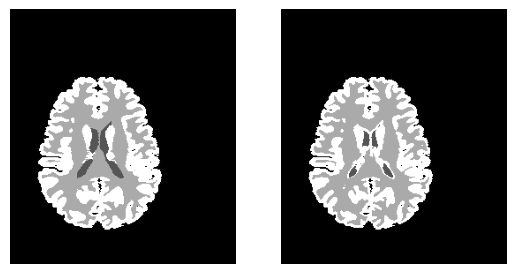

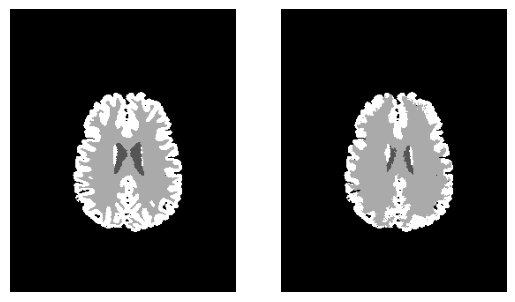

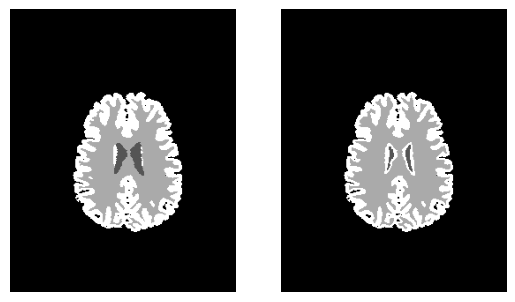

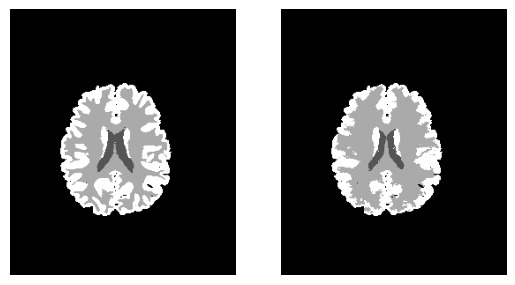

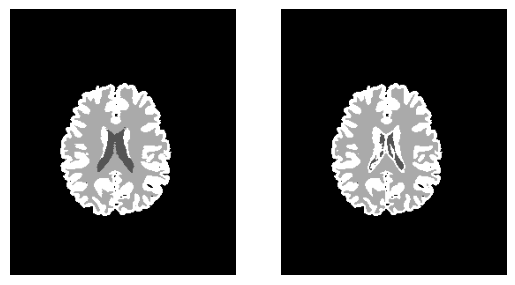

In [17]:

# Read all patients in the "test-set" directory:
test_set_path = './test-set'
patients_list = read_patients_list(test_set_path)

# Define path to segmentatios directory:
segmentations_dir = '/Volumes/SD ALEX/segmentations'

# Define the methods applied for initialization of EM:
methods_list = ['label_propagation', 'tissues_model']
#methods_list = ['k_means', 'tissues_model', 'label_propagation']


# Skull-strip these images with their labels:
for patient_name in patients_list:
    
    # Read image, mask, ground truth labels and perform a skull-stripping:
    im = sitk.GetArrayFromImage(sitk.ReadImage(test_set_path + "/testing-images/" + patient_name + ".nii.gz"))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(test_set_path + "/testing-mask/" + patient_name + "_1C.nii.gz"))
    gt_labels = sitk.GetArrayFromImage(sitk.ReadImage(test_set_path + "/testing-labels/" + patient_name + "_3C.nii.gz"))
    skull_stripped = im*(mask>0)
    
    for method in methods_list:
        
        # Labels are initialized according to "method"    
        initialization_labels = EM_initialization_method(skull_stripped, method, mask, patient_name, segmentations_dir)

        fig, axs = plt.subplots(1,2)
        axs[0].imshow(gt_labels[150,::-1,:], cmap = "gray")
        axs[0].axis('off')
        axs[1].imshow(initialization_labels[150,::-1,:], cmap ="gray")
        axs[1].axis('off')
        plt.show()
        
        
        """
        # Improve segmentation with labels generated by EM algorithm
        final_labels, _ = run_em(skull_stripped, initialization_labels, mask, gt_labels)
        
        plt.imshow(final_labels[160,::-1,:], cmap ="gray")
        plt.axis('off')
        plt.show()
        """